In [1]:
import warnings
import matplotlib
import pandas as pd
import numpy as np
from IPython.display import Image
from pylab import rcParams
from IPython.display import Image
warnings.filterwarnings('ignore')
# Default parameters for plots
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.titlesize'] = 16
matplotlib.rcParams['figure.figsize'] = [16, 9]
#np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', None)

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import seaborn as sns
import time

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import linear_model
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [76]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

In [3]:
cd E:\Optimal Portfolio

E:\Optimal Portfolio


In [55]:
sp_data = yf.download(["^VIX","^GSPC"],'1999-01-01','2023-05-26')

[*********************100%***********************]  2 of 2 completed


In [62]:
close_data = sp_data['Adj Close']
close_data.columns = ['GSPC','VIX']
close_data.tail()

,GSPC,VIX
Date,,
2023-05-19,4191.979980,16.809999
2023-05-22,4192.629883,17.209999
2023-05-23,4145.580078,18.530001
2023-05-24,4115.240234,20.030001
2023-05-25,4151.279785,19.139999


In [63]:
close_data['log_VIX'] = np.log(close_data['VIX'])
close_data['return_GSPC'] = close_data['GSPC'].pct_change()
close_data['return_VIX'] = close_data['log_VIX'].diff()

In [64]:
close_data = close_data.iloc[1:]

In [65]:
close_data.head()

,GSPC,VIX,log_VIX,return_GSPC,return_VIX
Date,,,,,
1999-01-05,1244.780029,24.459999,3.197039,0.013582,-0.067575
1999-01-06,1272.339966,23.340000,3.150169,0.022140,-0.046870
1999-01-07,1269.729980,24.370001,3.193353,-0.002051,0.043184
1999-01-08,1275.089966,23.280001,3.147595,0.004221,-0.045758
1999-01-11,1263.880005,25.459999,3.237109,-0.008792,0.089514


In [67]:
close_data['abs_return_GSPC'] = np.abs(close_data['return_GSPC'])

In [66]:
len(close_data)

6138

**Consider the following model on predicting the VIX**



Let $X_{t}$ and $\sigma_{t}^{2}$ be the return of GSPC and the VIX at time $t$. Assume that



$$\ln\big(\sigma_{t}^{2}\big) = \alpha_{0} + \alpha_{1}\ln\big(\sigma_{t-1}^{2}\big) + \cdots + \alpha_{p}\ln\big(\sigma_{t-p}^{2}\big) + \beta_{1}X_{t-1} + \cdots + \beta_{p}X_{t-p} + \gamma_{1}\vert X_{t-1}\vert + \cdots + \gamma_{p}\vert X_{t-p}\vert.$$

In [68]:
def vix_reg(df,r=0.8,p=1):
    ddf = df.copy()
    for i in range(1,p+1):
        ddf[f'log_VIX{i}'] = ddf.log_VIX.shift(i)
        ddf[f'return_GSPC{i}'] = ddf.return_GSPC.shift(i)
        ddf[f'abs_return_GSPC{i}'] = ddf.abs_return_GSPC.shift(i)
    ddf = ddf.dropna()
    train_data = ddf[:int(r*len(ddf))]
    test_data = ddf[int(r*len(ddf)):]
    X_train = train_data[[f'log_VIX{i}' for i in range(1,p+1)] + [f'return_GSPC{i}' for i in range(1,p+1)] + 
                         [f'abs_return_GSPC{i}' for i in range(1,p+1)]].values
    Y_train = train_data[['log_VIX']].values
    X_test = test_data[[f'log_VIX{i}' for i in range(1,p+1)] + [f'return_GSPC{i}' for i in range(1,p+1)] + 
                         [f'abs_return_GSPC{i}' for i in range(1,p+1)]].values
    Y_test = test_data[['log_VIX']].values
    vol_reg = LinearRegression().fit(X_train, Y_train)
    return pd.DataFrame({"Data":['Train','Test'], f"p={p}":[vol_reg.score(X_train,Y_train),vol_reg.score(X_test,Y_test)]})

In [69]:
vix_reg(close_data,r=0.7,p=2)

,Data,p=2
0,Train,0.967442
1,Test,0.951993


**To find the best $p$, the following function determines the $R^{2}$ on the training and on the testing data. We define the testing data to be the last $20\%$ of the series.**

In [70]:
result_df = []
for p in range(1,10):
    result_df.append(vix_reg(close_data,r=0.7,p=p).set_index('Data').T)
pd.concat(result_df)

Data,Train,Test
p=1,0.967276,0.952031
p=2,0.967442,0.951993
p=3,0.967564,0.951937
p=4,0.967598,0.951911
p=5,0.967704,0.951917
p=6,0.967750,0.951898
p=7,0.967901,0.951632
p=8,0.967910,0.951645
p=9,0.967992,0.951527


**$p=1$ gives the highest $R^{2}$ on the testing set. In general, the model is slightly overfitting.**

In [71]:
p=1
df = close_data.copy()
for i in range(1,p+1):
    df[f'log_VIX{i}'] = df.log_VIX.shift(i)
    df[f'return_GSPC{i}'] = df.return_GSPC.shift(i)
    df[f'abs_return_GSPC{i}'] = df.abs_return_GSPC.shift(i)
df = df.dropna()
train_data = df[:int(0.8*len(df))]
test_data = df[int(0.8*len(df)):]
X_train = train_data[[f'log_VIX{i}' for i in range(1,p+1)] + [f'return_GSPC{i}' for i in range(1,p+1)] + 
                     [f'abs_return_GSPC{i}' for i in range(1,p+1)]].values
Y_train = train_data[['log_VIX']].values
X_test = test_data[[f'log_VIX{i}' for i in range(1,p+1)] + [f'return_GSPC{i}' for i in range(1,p+1)] + 
                   [f'abs_return_GSPC{i}' for i in range(1,p+1)]].values
Y_test = test_data[['log_VIX']].values
vix_reg = LinearRegression().fit(X_train, Y_train)

In [72]:
pY_test = vix_reg.predict(X_test)

**A graph comparing the predicted logVIX and the actual logVIX on the testing set.**

Text(0.5, 1.0, 'Plot of Predicted vs Actual logVIX on testing')

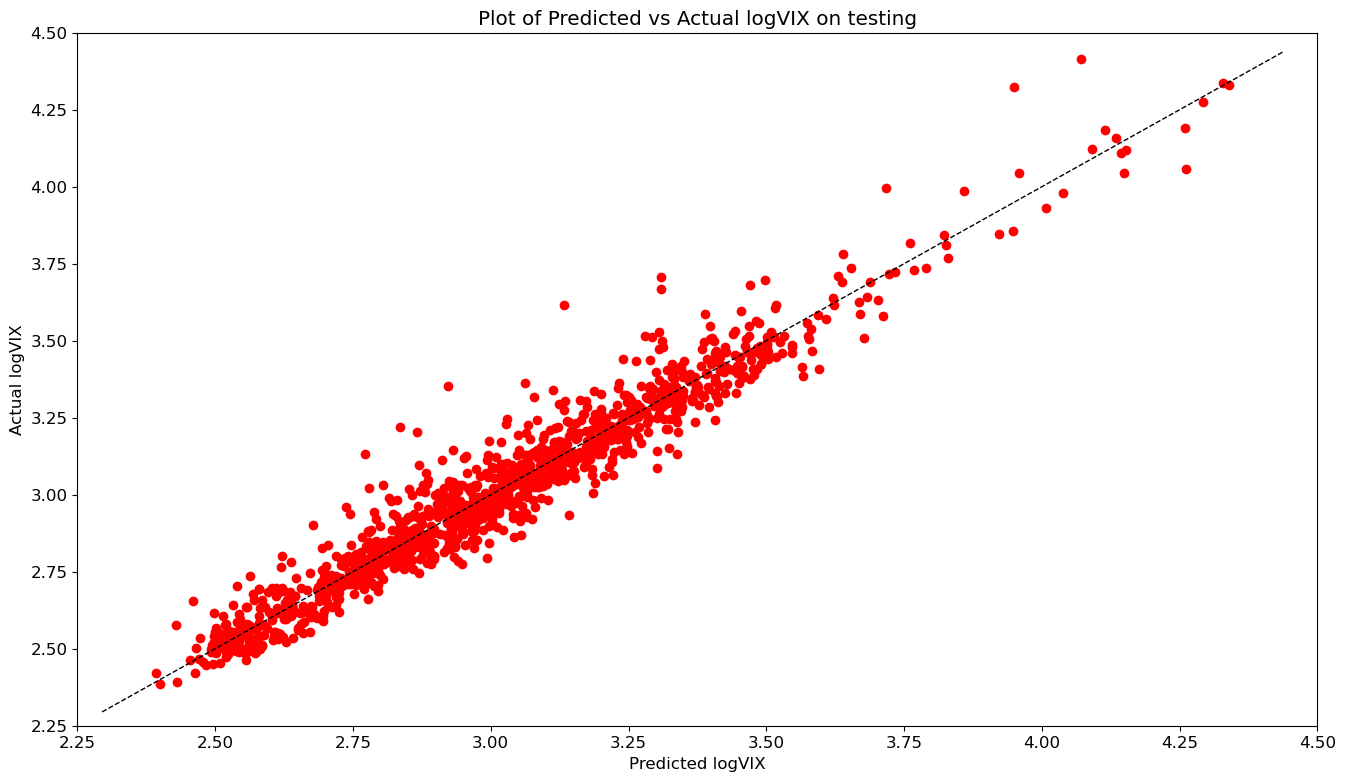

In [74]:
plt.scatter(pY_test,Y_test,color='red')
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
plt.xlim(2.25, 4.5)
plt.ylim(2.25, 4.5)
plt.xlabel('Predicted logVIX')
plt.ylabel('Actual logVIX')
plt.title('Plot of Predicted vs Actual logVIX on testing')

In [75]:
pY_train = vix_reg.predict(X_train)

In [77]:
print(
    pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [rmse(pY_train.reshape(-1), Y_train.reshape(-1)), rmse(pY_test.reshape(-1), Y_test.reshape(-1)),],
                "MAE": [mae(pY_train.reshape(-1), Y_train.reshape(-1)),mae(pY_test.reshape(-1), Y_test.reshape(-1)),],
                "MAPE": [mape(pY_train.reshape(-1), Y_train.reshape(-1)),mape(pY_test.reshape(-1), Y_test.reshape(-1)),],
            }
        )
    )

    Data     RMSE      MAE     MAPE
0  Train 0.067315 0.048052 1.639608
1   Test 0.078506 0.056073 1.839782
